In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import ast
from joblib import dump, load

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
data = pd.read_csv('./data.csv')
# Removing the duplicates
data.drop_duplicates(subset=['artists','name'],inplace = True)
# Key mapping
note_dict = { 0: 'C', 1: 'C#', 2: 'D', 3: 'D#', 4: 'E', 5: 'F', 6: 'F#', 7: 'G', 8: 'G#', 9: 'A', 10: 'A#', 11: 'B' }
data['key_category'] = data['key'].map(note_dict)
# Removing 1921-1951 years
data = data[data['year'] >= 1951]
# Adding decade feature
decades = pd.cut(data['year'],7,labels=['1951-1961','1961-1971','1971-1981','1981-1991','1991-2001','2001-2011','2011-2020'])
data['decade'] = decades 
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 128627 entries, 1154 to 169907
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   acousticness      128627 non-null  float64 
 1   artists           128627 non-null  object  
 2   danceability      128627 non-null  float64 
 3   duration_ms       128627 non-null  int64   
 4   energy            128627 non-null  float64 
 5   explicit          128627 non-null  int64   
 6   id                128627 non-null  object  
 7   instrumentalness  128627 non-null  float64 
 8   key               128627 non-null  int64   
 9   liveness          128627 non-null  float64 
 10  loudness          128627 non-null  float64 
 11  mode              128627 non-null  int64   
 12  name              128627 non-null  object  
 13  popularity        128627 non-null  int64   
 14  release_date      128627 non-null  object  
 15  speechiness       128627 non-null  float64 
 16  temp

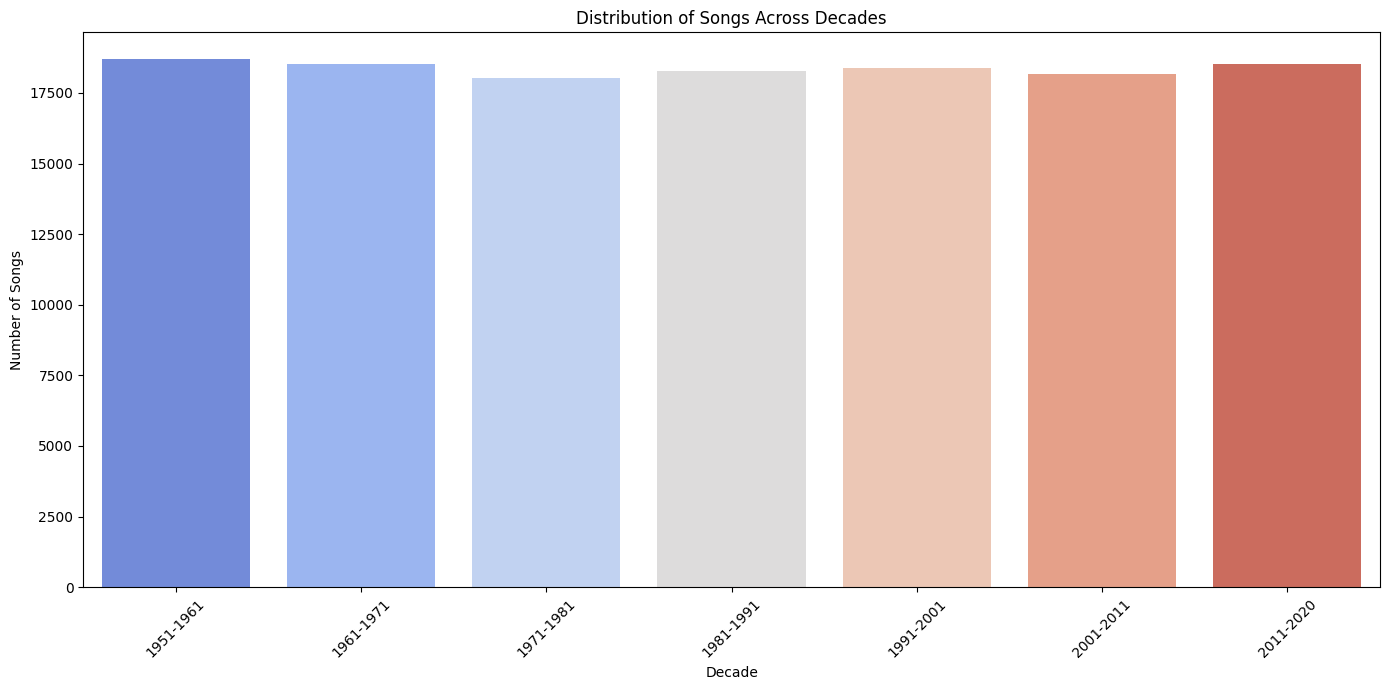

In [4]:
decade_counts = data['decade'].value_counts().sort_index()

plt.figure(figsize=(14, 7))
sns.barplot(x=decade_counts.index, y=decade_counts.values, hue=decade_counts.index, palette="coolwarm")

plt.title('Distribution of Songs Across Decades')
plt.xlabel('Decade')
plt.ylabel('Number of Songs')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The plot illustrates how the tracks are (roughly evenly) distributed over the decades in the dataset

In [5]:
artist_popularity_by_decade = data.groupby(['decade', 'artists'], observed=False)['popularity'].mean().reset_index()

# Sort the artists within each decade by popularity
artist_popularity_by_decade = artist_popularity_by_decade.sort_values(by=['decade', 'popularity'], ascending=[True, False])

# Get the top 5 artists for each decade
top_artists_by_decade = artist_popularity_by_decade.groupby('decade', observed=False).head(5)
# top_artists_by_decade

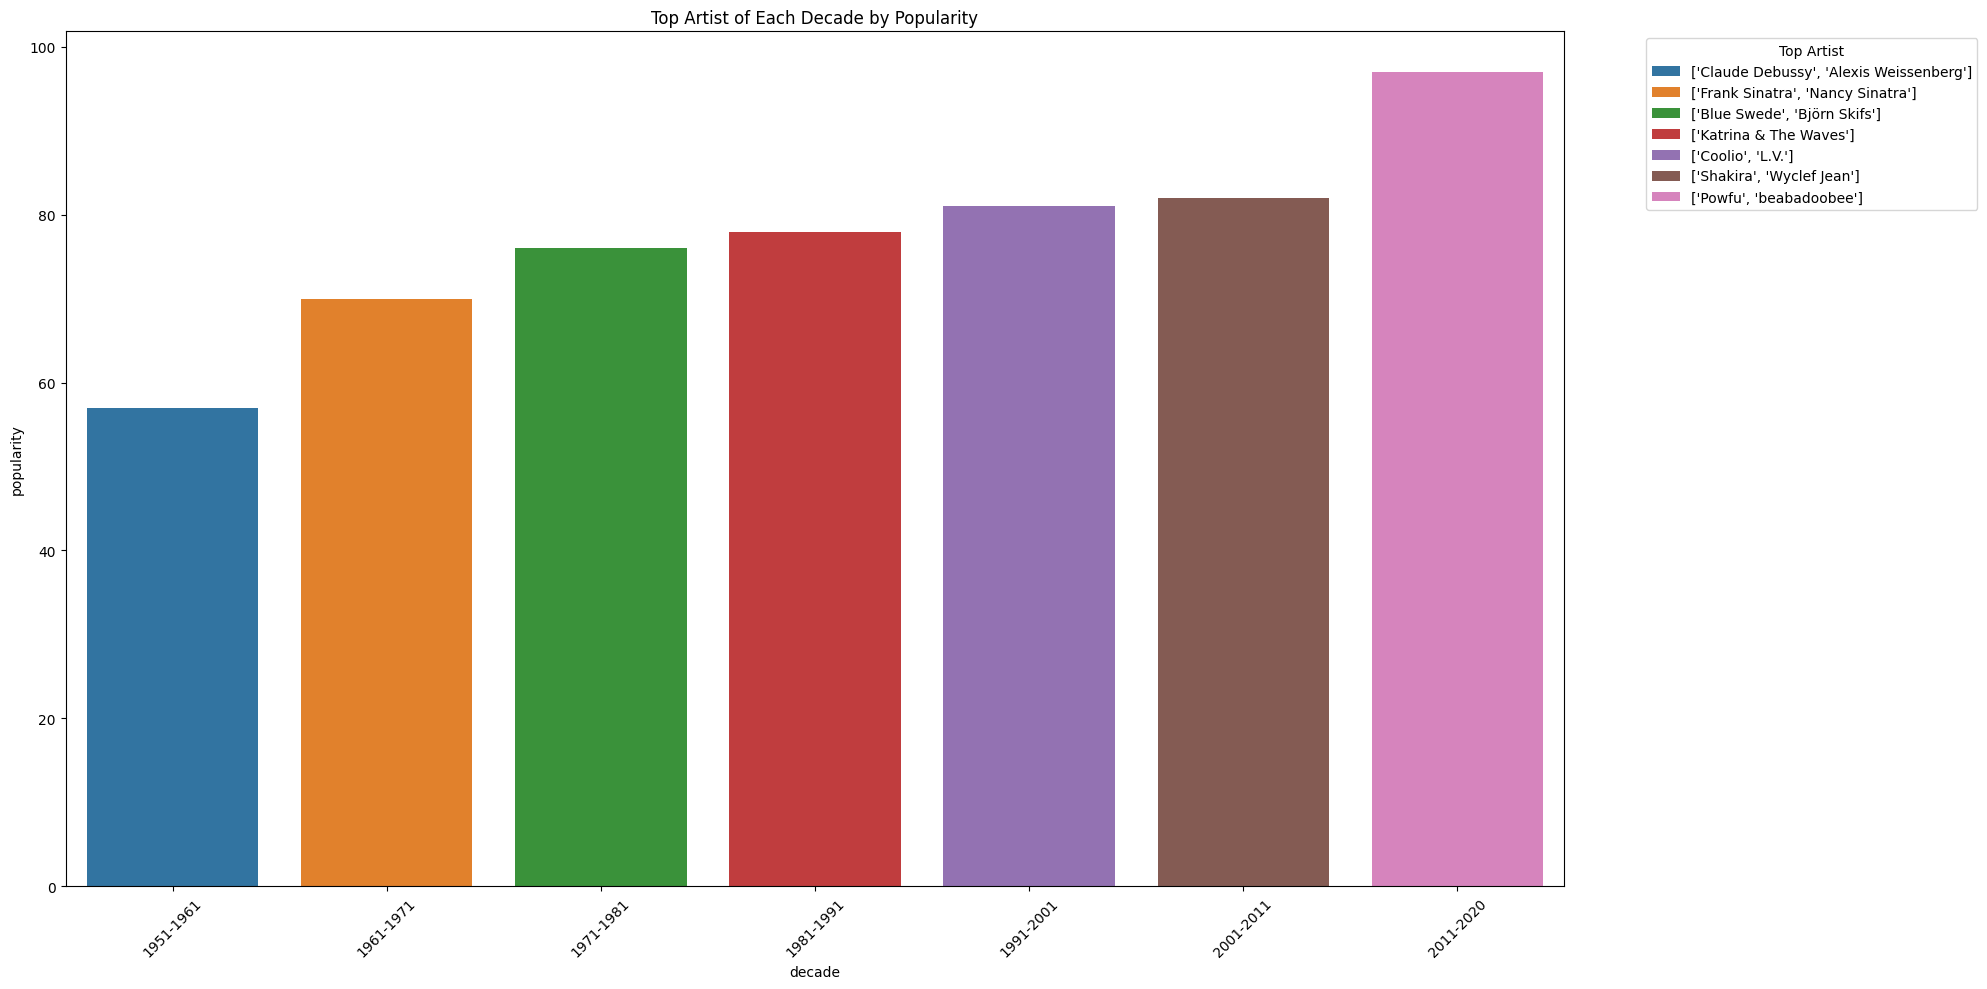

In [6]:
plt.figure(figsize=(20, 10))

# top artist for each decade
top_artist_per_decade = top_artists_by_decade.groupby('decade', observed=False).first().reset_index()
sns.barplot(
    x='decade',
    y='popularity',
    hue='artists',  # This will color code by artist
    data=top_artist_per_decade,
    dodge=False
)

plt.legend(title='Top Artist', bbox_to_anchor=(1.05, 1), loc=2)
plt.xticks(rotation=45)  
plt.title('Top Artist of Each Decade by Popularity')
plt.tight_layout()
plt.show()

This barplot illustrates the distribution of popularity of songs in the dataset across different decades, starting from the 1950s to the 2010s.

In [7]:
data['artists'] = data['artists'].apply(ast.literal_eval)
data['artist_count'] = data['artists'].apply(len)

# Explode the 'artists' column to have one artist per row
all_artists = data.explode('artists')
top_20_artists_by_popularity = all_artists.groupby('artists')['popularity'].mean().sort_values(ascending=False).head(20)
top_20_artists_by_appearance = all_artists['artists'].value_counts().head(20)

top_artists_by_popularity_df = top_20_artists_by_popularity.reset_index()
top_artists_by_appearance_df = top_20_artists_by_appearance.reset_index()
top_artists_by_appearance_df.columns = ['artists', 'appearances']

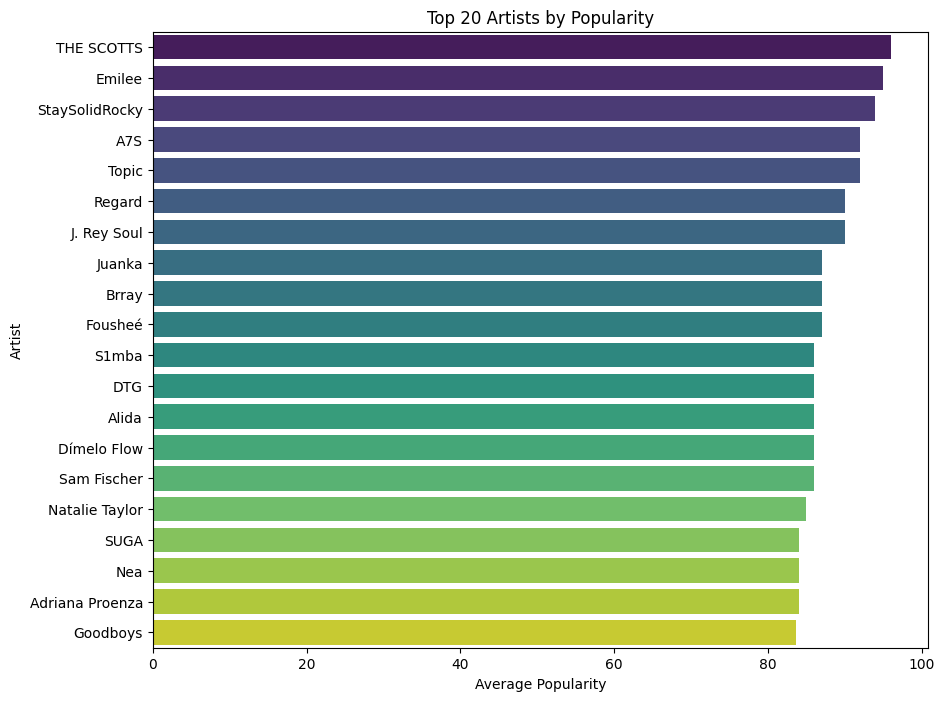

In [8]:
plt.figure(figsize=(10, 8))
sns.barplot(x='popularity', y='artists', data=top_artists_by_popularity_df, palette='viridis', hue='artists')
plt.title('Top 20 Artists by Popularity')
plt.xlabel('Average Popularity')
plt.ylabel('Artist')
plt.show()

This plot illustrates the top 20 artists by average popularity. This metric reflects contemporary listener preferences and trends on Spotify. 

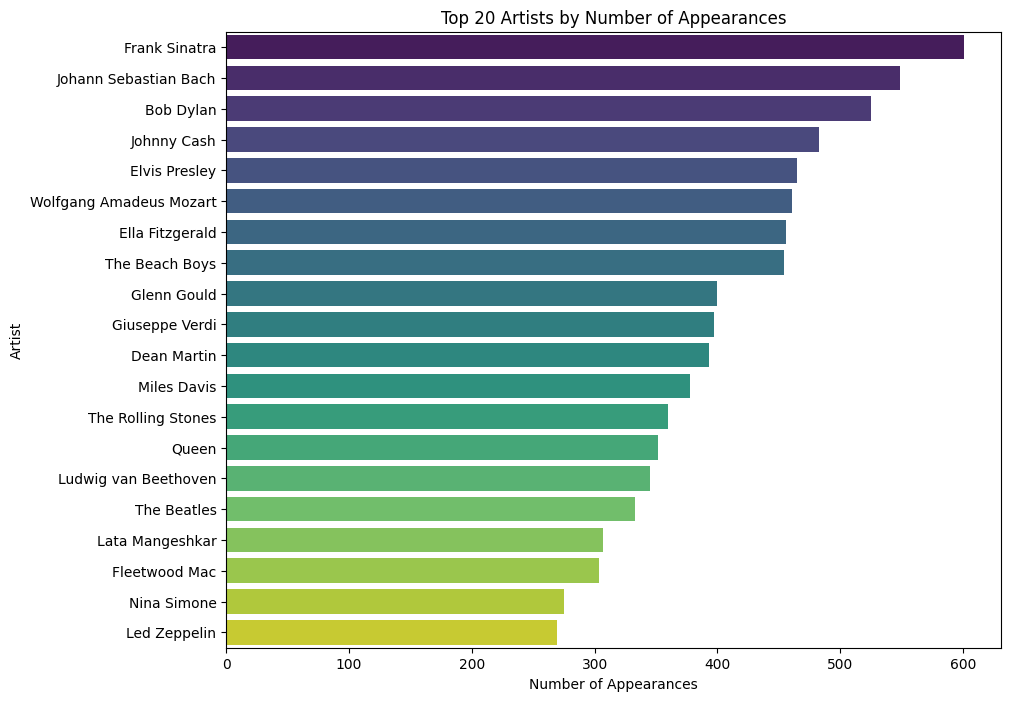

In [9]:
plt.figure(figsize=(10, 8))
sns.barplot(x='appearances', y='artists', data=top_artists_by_appearance_df, palette='viridis', hue='artists')
plt.title('Top 20 Artists by Number of Appearances')
plt.xlabel('Number of Appearances')
plt.ylabel('Artist')
plt.show()

The second plot showcases the top 20 artists by the number of appearances in the dataset. This includes a surprising number of classical and legacy artists such as Johann Sebastian Bach, Frank Sinatra, and Bob Dylan. 
 - While the first plot represents current popular tastes, the second plot's inclusion of historical and classical artists highlights the comprehensive nature of Spotify's catalog. It reflects the platform's vast archival content.

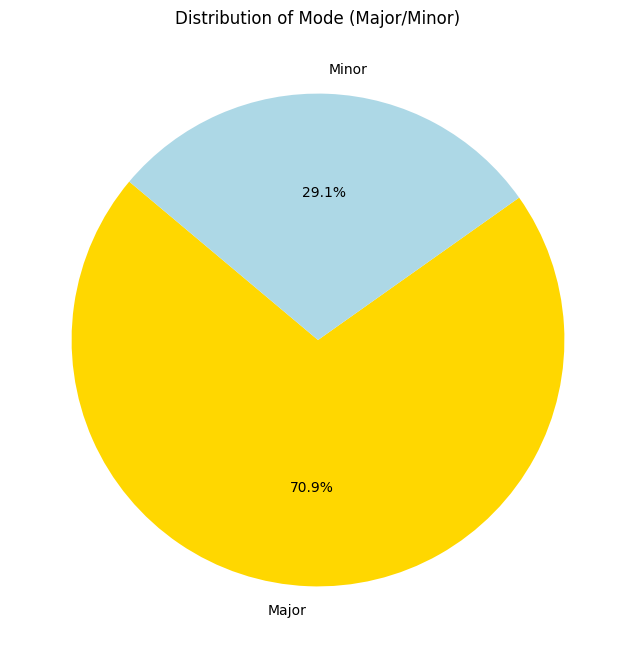

In [10]:
mode_counts = data['mode'].value_counts()
mode_labels = ['Major' if index == 1 else 'Minor' for index in mode_counts.index]
mode_colors = ['gold', 'lightblue']

plt.figure(figsize=(8, 8))
plt.pie(mode_counts, labels=mode_labels, colors=mode_colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Mode (Major/Minor)')
plt.show()

This pie chart shows the overall distribution of song modes in the dataset. It reveals that songs in a Major key are more prevalent or popular in the dataset, potentially indicating a general listener preference for the typically brighter, happier tonality of Major keys.
* This preference might reflect cultural tendencies towards music that conveys positivity, which is often associated with Major key 
songs.


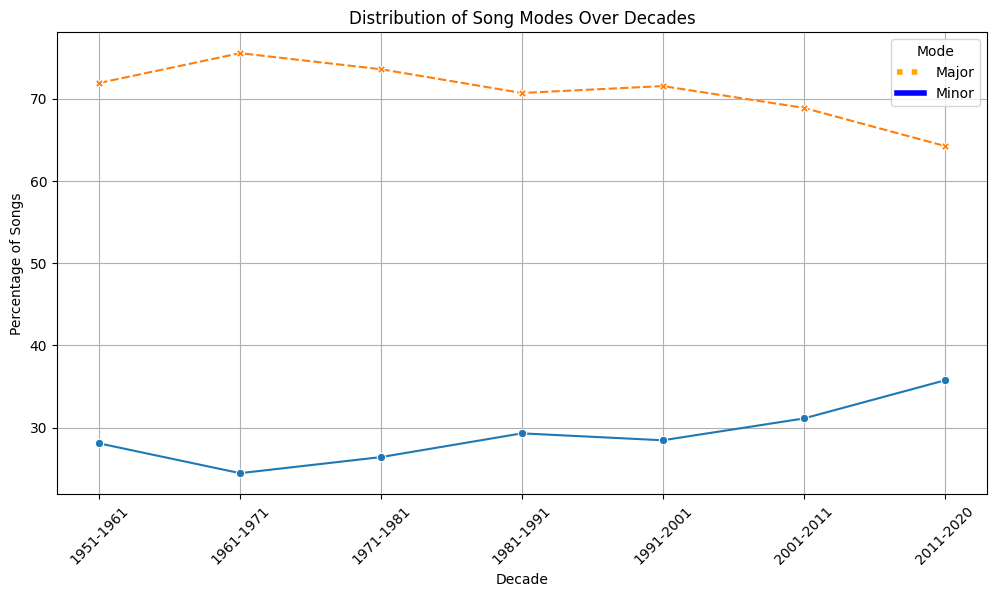

In [11]:
# Group by decade and calculate the proportion of songs in each mode
mode_by_decade = data.groupby('decade', observed=False)['mode'].value_counts(normalize=True).unstack() * 100

plt.figure(figsize=(12, 6))
sns.lineplot(data=mode_by_decade, markers=True)
plt.xlabel('Decade')
plt.ylabel('Percentage of Songs')
plt.title('Distribution of Song Modes Over Decades')
plt.xticks(rotation=45)  
plt.grid(True)  
legend_handles = [Line2D([0], [0], color='orange', lw=4, label='Major', linestyle='dotted'),
                  Line2D([0], [0], color='blue', lw=4, label='Minor')]
plt.legend(handles=legend_handles, title='Mode')
plt.show()

This second plot provides a time-series analysis of the distribution of modes over several decades. It shows a consistent dominance of Major mode songs throughout the periods analyzed. Minor mode songs remain less frequent but show a slight increase in later decades.
* The slight increase in the proportion of Minor mode songs in recent decades could suggest a diversification in musical tastes, possibly influenced by changes in societal moods, music production techniques, or the influence of different music genres that favor Minor keys.

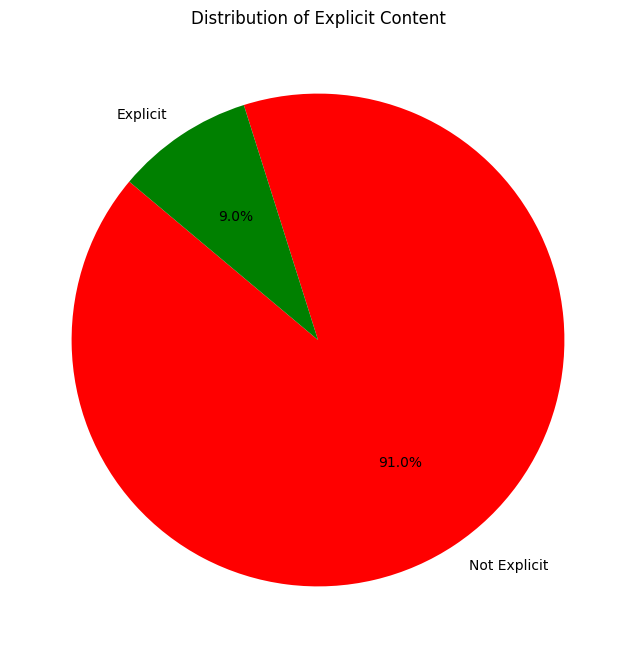

In [12]:
explicit_counts = data['explicit'].value_counts()
explicit_labels = ['Explicit' if index == 1 else 'Not Explicit' for index in explicit_counts.index]
explicit_colors = ['red', 'green']

plt.figure(figsize=(8, 8))
plt.pie(explicit_counts, labels=explicit_labels, colors=explicit_colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Explicit Content')
plt.show()

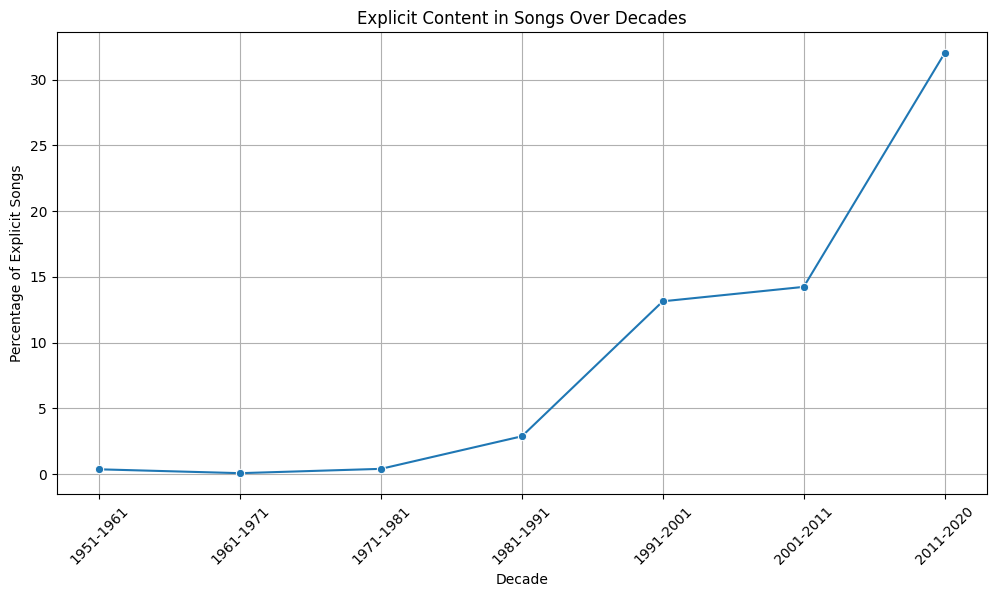

In [13]:
explicit_by_decade = data.groupby('decade', observed=False)['explicit'].mean().reset_index()
explicit_by_decade['explicit'] = explicit_by_decade['explicit'] * 100

plt.figure(figsize=(12, 6))
sns.lineplot(x='decade', y='explicit', data=explicit_by_decade, marker='o')
plt.xlabel('Decade')
plt.ylabel('Percentage of Explicit Songs')
plt.title('Explicit Content in Songs Over Decades')
plt.xticks(rotation=45)  
plt.grid(True)  
plt.show()

* The pie chart illustrates the overall distribution of explicit content within the dataset, and shows a minority but significant portion of the catalog that includes explicit lyrics.
* The second line graph displays the trend in the percentage of songs with explicit content from the 1950s to the 2020s. It reveals a dramatic increase in the proportion of explicit songs over the last few decades.


The rise in explicit content reflects broader cultural shifts towards more openness in expressing themes of adult nature in music. This could be associated with societal changes, where topics that were once considered taboo are now more openly discussed and portrayed in media.

The trend might also indicate a shift towards greater artistic freedom, where artists feel more empowered to express themselves without restrictions, reflecting authentic experiences and emotions.


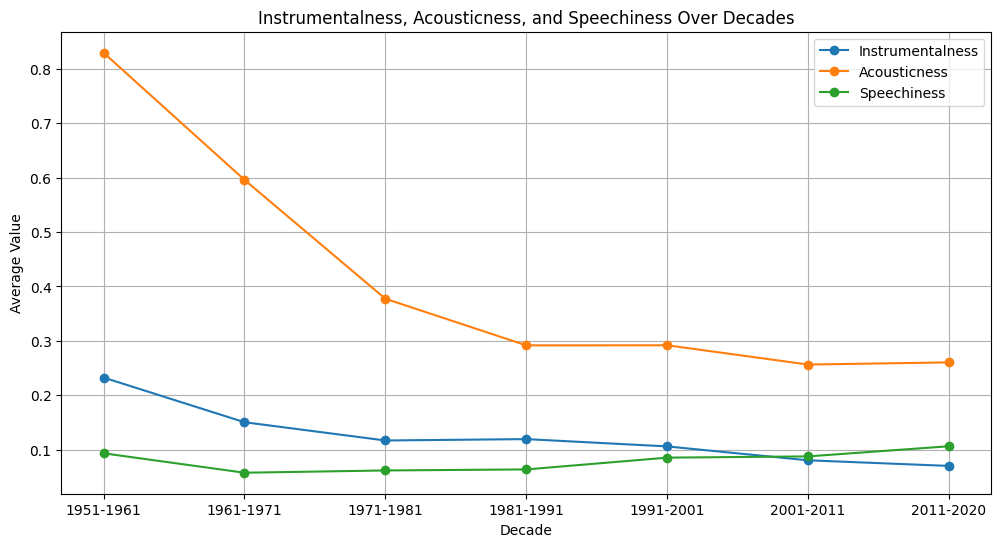

In [14]:
means_by_decade = data.groupby('decade', observed=False)[['instrumentalness', 'acousticness', 'speechiness']].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot('decade', 'instrumentalness', data=means_by_decade, marker='o', label='Instrumentalness')
plt.plot('decade', 'acousticness', data=means_by_decade, marker='o', label='Acousticness')
plt.plot('decade', 'speechiness', data=means_by_decade, marker='o', label='Speechiness')

plt.title('Instrumentalness, Acousticness, and Speechiness Over Decades')
plt.xlabel('Decade')
plt.ylabel('Average Value')
plt.legend()
plt.grid(True)
plt.show()

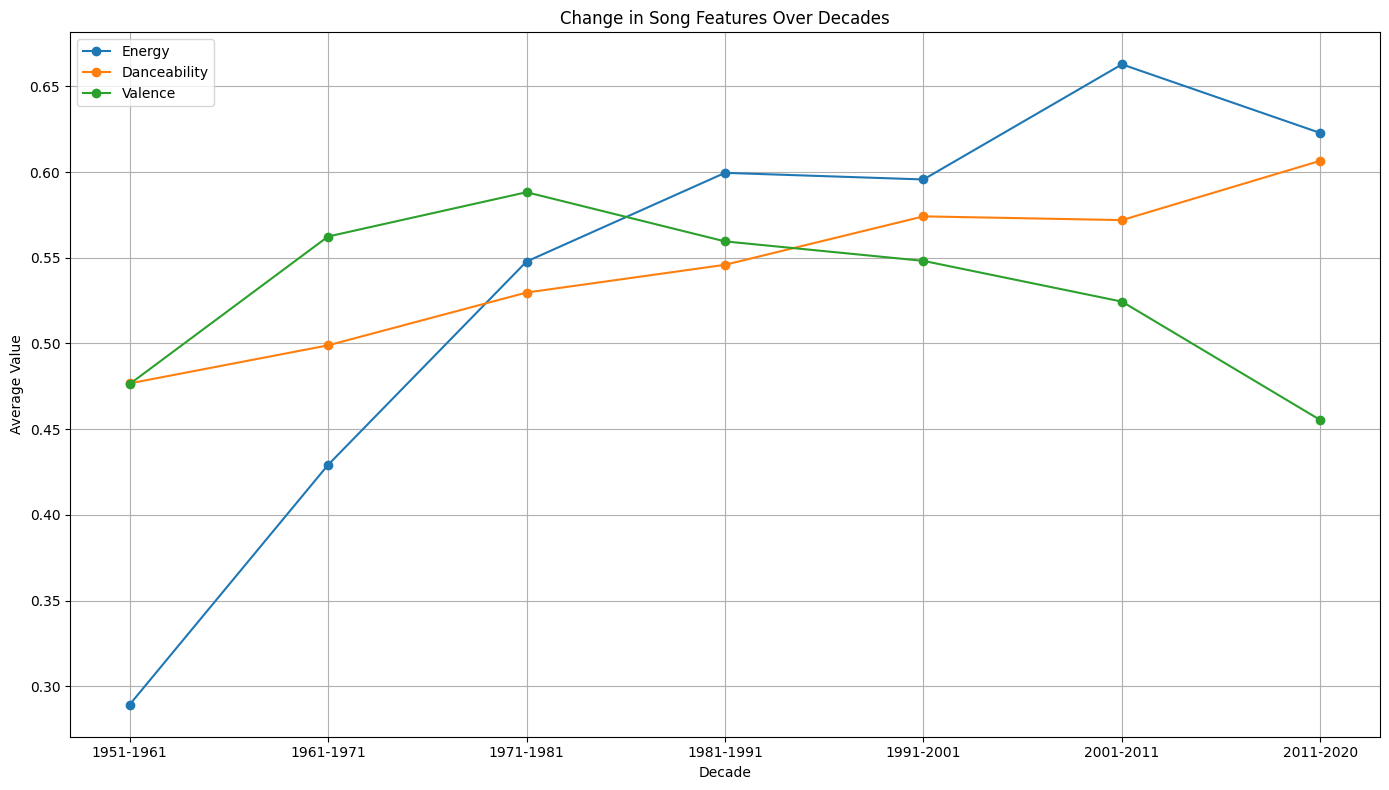

In [15]:
grouped_by_decade = data.groupby('decade', observed=False)
mean_features_by_decade = grouped_by_decade[['energy', 'danceability', 'valence']].mean()

plt.figure(figsize=(14, 8))
plt.plot(mean_features_by_decade.index, mean_features_by_decade['energy'], label='Energy', marker='o')
plt.plot(mean_features_by_decade.index, mean_features_by_decade['danceability'], label='Danceability', marker='o')
plt.plot(mean_features_by_decade.index, mean_features_by_decade['valence'], label='Valence', marker='o')

plt.title('Change in Song Features Over Decades')
plt.xlabel('Decade')
plt.ylabel('Average Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The first plot shows a clear decline in instrumentalness, suggesting a shift towards more vocal-centric music over time. 
Acousticness has also decreased, reflecting the advent and rise of electronic and synthesized music production. 
Speechiness remains relatively stable but low, indicating that spoken word is not a predominant element in the majority of popular music.

The second plot indicates a rise in all three attributes, particularly in the recent decades. This suggests a trend towards more vibrant, energetic, and danceable music, which aligns with global shifts towards more engaging and rhythmic music forms in mainstream music.


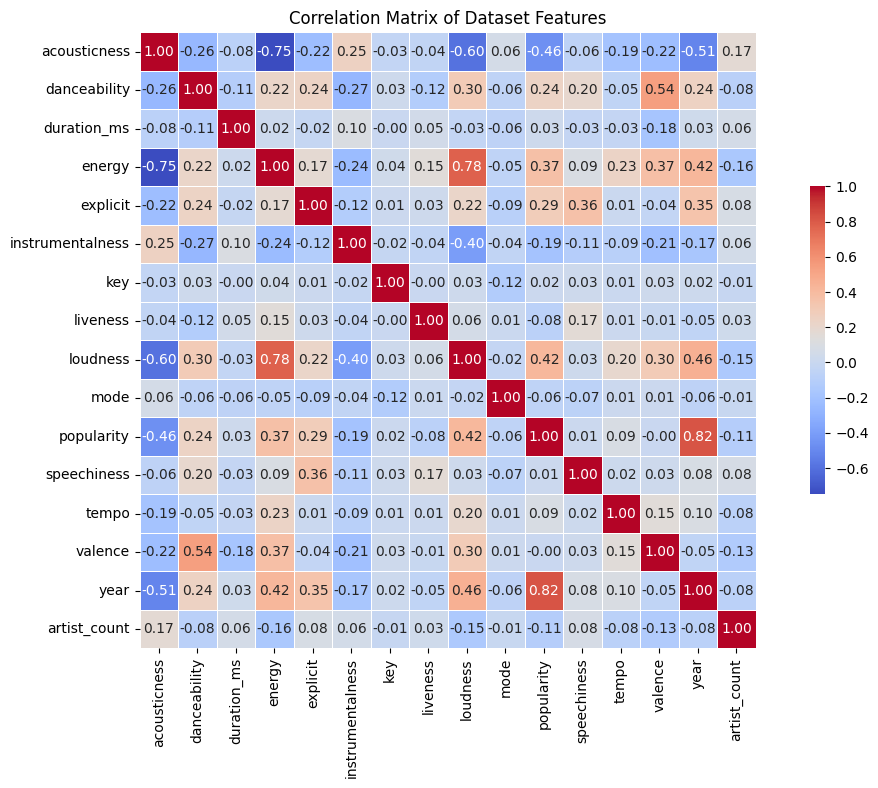

In [16]:
numerical_data = data.select_dtypes(include=[np.number])
correlation_matrix = numerical_data.corr()

plt.figure(figsize=(14, 8))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, cbar_kws={"shrink": .5}, linewidths=.5)

plt.title('Correlation Matrix of Dataset Features')
plt.show()

The correlation matrix provides a detailed view of how different musical features from the Spotify dataset are interrelated.
* A strong positive correlation (0.78) between **energy** and **loudness** suggests that louder tracks are perceived as more energetic.
* A strong negative correlation (-0.75) indicates that songs with higher **acousticness** tend to have **lower energy**, which aligns with the acoustic nature being opposite to the electronic/synthetic feel.
* There is a noticeable negative correlation between **acousticness** and song popularity, indicating that songs with lower acousticness tend to be more popular on Spotify.
* Both **energy** and **loudness** have a positive correlation with popularity. This suggests that songs that are perceived as more energetic and louder tend to be more popular.
* Similarly, **danceability** shows a positive correlation with popularity, implying that more danceable songs generally achieve higher popularity. This feature ties closely with music that is suitable for social settings, which often sees higher streaming numbers.
* For **instrumentalness**, there is a slight negative correlation with popularity, suggesting that songs with more vocal content (i.e., less instrumental) are more popular.

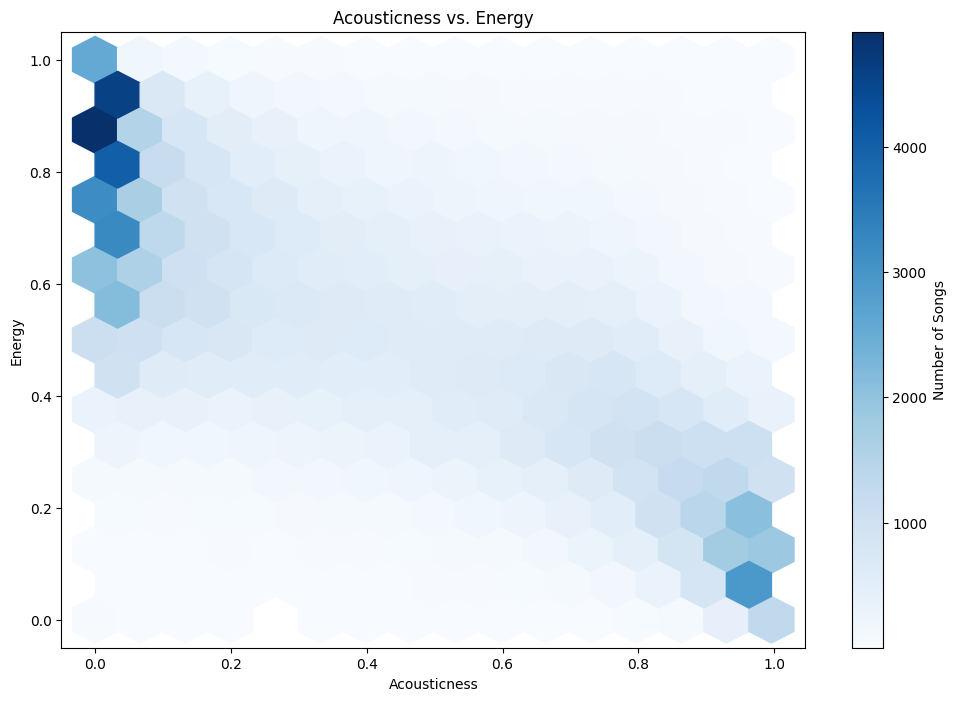

In [17]:
plt.figure(figsize=(12, 8))
plt.hexbin(data['acousticness'], data['energy'], gridsize=15, cmap='Blues', mincnt=1)
plt.colorbar(label='Number of Songs')
plt.xlabel('Acousticness')
plt.ylabel('Energy')
plt.title('Acousticness vs. Energy')
plt.show()

This plot, once again, reflects a preference for more electronically produced or less acoustic music among Spotify listeners.

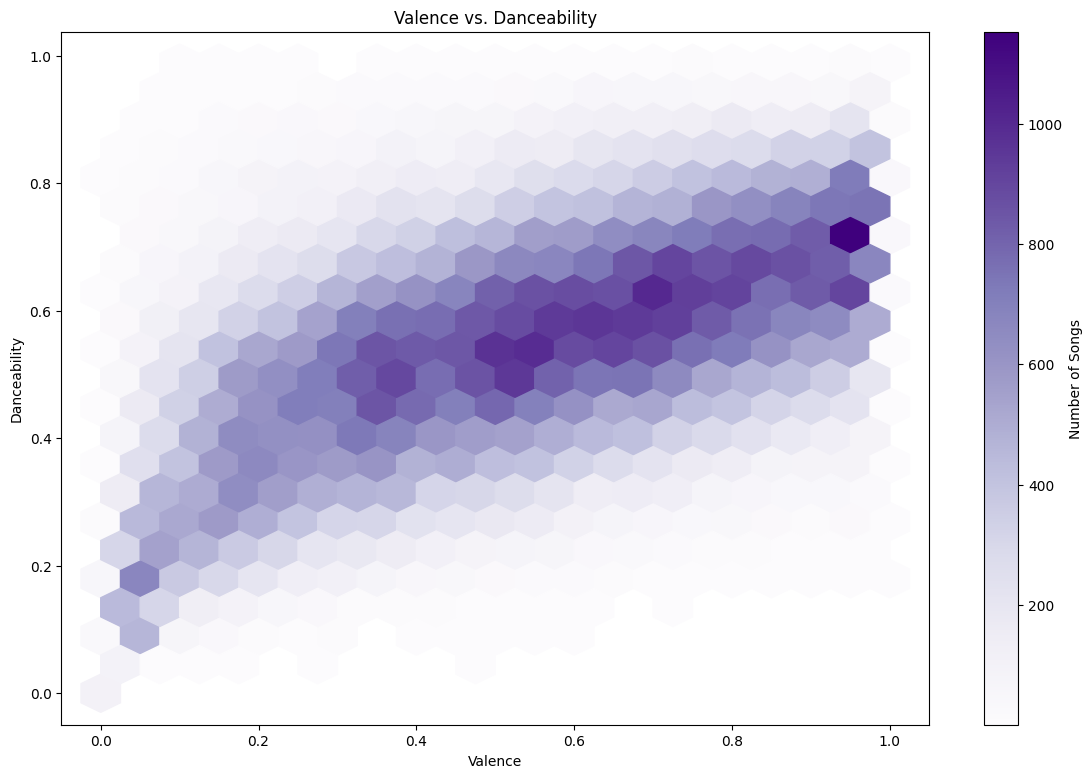

In [18]:
plt.figure(figsize=(14, 9))
plt.hexbin(data['valence'], data['danceability'], gridsize=20, cmap='Purples', mincnt=1)
plt.colorbar(label='Number of Songs')
plt.xlabel('Valence')
plt.ylabel('Danceability')
plt.title('Valence vs. Danceability')
plt.show()

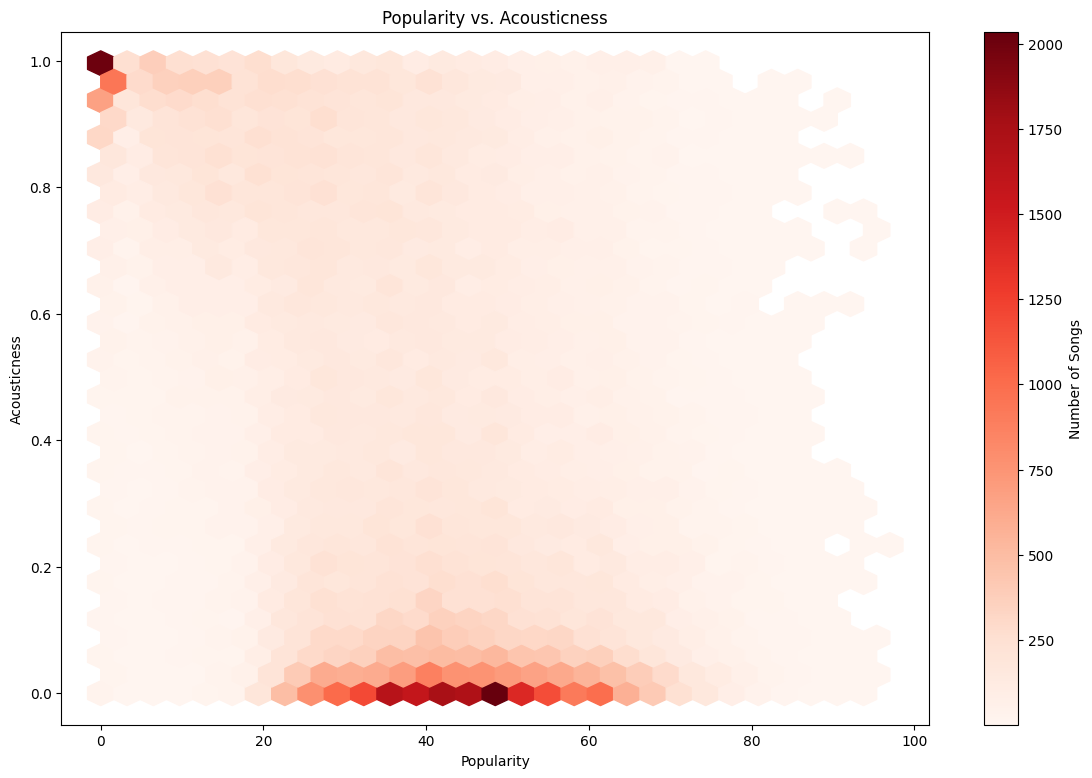

In [19]:
plt.figure(figsize=(14, 9))
plt.hexbin(data['popularity'], data['acousticness'], gridsize=30, cmap='Reds', mincnt=1)
plt.colorbar(label='Number of Songs')
plt.xlabel('Popularity')
plt.ylabel('Acousticness')
plt.title('Popularity vs. Acousticness')
plt.show()

* The first plot shows a hexbin visualization between valence (the musical positivity) and danceability of songs. The densest area, shown in dark purple, suggests a strong concentration of songs with high danceability and moderate to high valence. This indicates that songs which are more danceable tend to also be more positive, aligning with the idea that upbeat, happy songs are more engaging for dancing.

* The second plot explores the relationship between acousticness and song popularity. The concentration of songs is higher at lower levels of acousticness and moderate popularity levels.
This suggests that less acoustic (more electronic or produced) songs tend to be more popular, reflecting a trend towards more produced music in popular genres.


## Machine learning ##

In [20]:
numerical_data.corr()['popularity']
cor_target = abs(numerical_data.corr()["popularity"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target> 0.1]
feature_cols = relevant_features.keys().to_list()
feature_cols

['acousticness',
 'danceability',
 'energy',
 'explicit',
 'instrumentalness',
 'loudness',
 'popularity',
 'year',
 'artist_count']

In [21]:
## preparing a dataset for training
df = data[feature_cols] # get a dataset with only selected features
df = df[~df.duplicated()==1]

In [22]:
#Split the data to train and validate 
# target column is popularity and we use 80% - 20% split
X_train, X_val, y_train, y_val = train_test_split(df.drop('popularity', axis=1), df['popularity'], test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

Training set: (102897, 8), (102897,)
Validation set: (25725, 8), (25725,)


In [23]:
scaler = MinMaxScaler()
cols = ['loudness', 'year']
X_train[cols] = scaler.fit_transform(X_train[cols])
X_val[cols] = scaler.transform(X_val[cols])
y_train = y_train / 100
y_val = y_val / 100

In [26]:
import os 
if os.path.exists('trained_model.joblib'):
    model = load('trained_model.joblib')
else:
    # create the model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    dump(model, 'trained_model.joblib')

# Perform cross-validation
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Calculate the average RMSE across all folds
rmse_scores = np.sqrt(-scores)
print("Cross-Validation RMSE: ", rmse_scores.mean())

Cross-Validation RMSE:  0.09594732336303899


In [27]:
# Predict on the validation set
y_val_pred = model.predict(X_val)

# Calculate evaluation metrics
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_val_pred)

print(f"Validation MSE: {mse:.8f}")
print(f"Validation RMSE: {rmse:.8f}")
print(f"Validation R² Score: {r2:.4f}")

Validation MSE: 0.00905040
Validation RMSE: 0.09513360
Validation R² Score: 0.7316


In [28]:
new_data = pd.read_csv('./new_data.csv')
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10818 entries, 0 to 10817
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              10818 non-null  object 
 1   artist_count      10818 non-null  int64  
 2   track_id          10818 non-null  object 
 3   popularity        10818 non-null  int64  
 4   year              10818 non-null  int64  
 5   explicit          10818 non-null  int64  
 6   danceability      10762 non-null  float64
 7   energy            10762 non-null  float64
 8   key               10762 non-null  float64
 9   loudness          10762 non-null  float64
 10  mode              10762 non-null  float64
 11  speechiness       10762 non-null  float64
 12  acousticness      10762 non-null  float64
 13  instrumentalness  10762 non-null  float64
 14  liveness          10762 non-null  float64
 15  valence           10762 non-null  float64
 16  tempo             10762 non-null  float6

In [29]:
new_data.drop_duplicates(inplace = True)
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7823 entries, 0 to 10696
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              7823 non-null   object 
 1   artist_count      7823 non-null   int64  
 2   track_id          7823 non-null   object 
 3   popularity        7823 non-null   int64  
 4   year              7823 non-null   int64  
 5   explicit          7823 non-null   int64  
 6   danceability      7776 non-null   float64
 7   energy            7776 non-null   float64
 8   key               7776 non-null   float64
 9   loudness          7776 non-null   float64
 10  mode              7776 non-null   float64
 11  speechiness       7776 non-null   float64
 12  acousticness      7776 non-null   float64
 13  instrumentalness  7776 non-null   float64
 14  liveness          7776 non-null   float64
 15  valence           7776 non-null   float64
 16  tempo             7776 non-null   float64
 17 

In [30]:
cols_to_keep = ['acousticness', 'danceability', 'energy', 'explicit', 'instrumentalness',
                'loudness', 'year', 'artist_count', 'popularity', 'track_id']  # include 'popularity' since we need it for evaluation

# Filter the DataFrame
filtered_df = new_data[cols_to_keep]
filtered_df = filtered_df.dropna()

filtered_df[['loudness', 'year']] = scaler.transform(filtered_df[['loudness', 'year']])
filtered_df['popularity'] /= 100
new_X_test = filtered_df.drop(['popularity', 'track_id'], axis=1)

new_X_test[cols] = scaler.transform(new_X_test[cols])  # Use the scaler fitted on the training data

# Now predict using the loaded model
new_predictions = model.predict(new_X_test)

new_actual_popularity = filtered_df['popularity']/100
new_rmse = np.sqrt(mean_squared_error(new_actual_popularity, new_predictions))
print("RMSE on test set:", new_rmse)

RMSE on test set: 0.11146444013023306


In [31]:
filtered_df['predicted_popularity'] = new_predictions
predicted_top_500 = filtered_df.sort_values(by='predicted_popularity', ascending=False).head(500)
actual_top_500 = filtered_df.sort_values(by='popularity', ascending=False).head(500)

common_songs = pd.merge(predicted_top_500, actual_top_500, on='track_id')
print(f"Number of common songs in both top 500 lists: {len(common_songs)}")

Number of common songs in both top 500 lists: 27


In [48]:
average_popularity_train = y_train.mean()
average_popularity_train /= 100
average_popularity_test = filtered_df['predicted_popularity'].mean()

print("Average popularity in the training data: ", average_popularity)
print("Average popularity on the test set: ", average_popularity_test)

Average popularity in the training data:  37.54207678313197
Average popularity on the test set:  0.105337859010631


In [42]:
non_zero_popularity = filtered_df['popularity'] > 0.05
non_zero = filtered_df[non_zero_popularity]
average_actual_popularity_test = non_zero['popularity'].mean()
print("Average actual popularity on the test set: ", average_actual_popularity_test)

Average actual popularity on the test set:  0.14703241895261848


In [57]:
average_pop_val = y_val_pred.mean()
print(average_pop_val)

0.3782010801193947


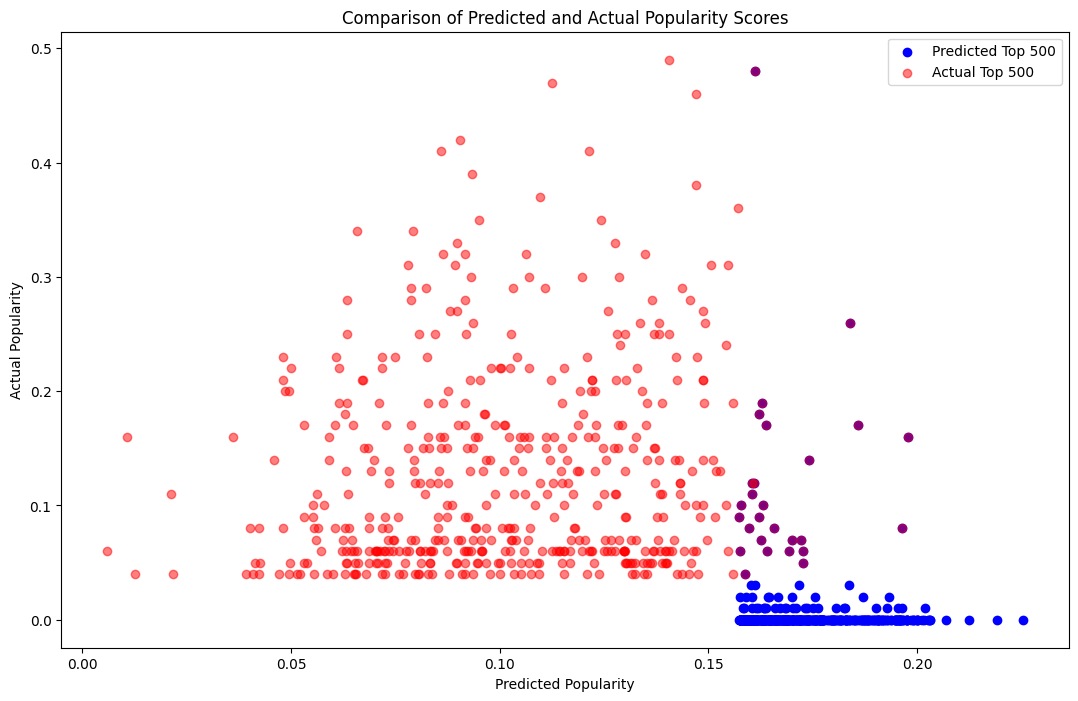

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(13, 8))
plt.scatter(predicted_top_500['predicted_popularity'], predicted_top_500['popularity'], color='blue', label='Predicted Top 500')
plt.scatter(actual_top_500['predicted_popularity'], actual_top_500['popularity'], color='red', alpha=0.5, label='Actual Top 500')
plt.title('Comparison of Predicted and Actual Popularity Scores')
plt.xlabel('Predicted Popularity')
plt.ylabel('Actual Popularity')
plt.legend()
plt.show()


5% of the top 500 songs were correctly classified in this range.

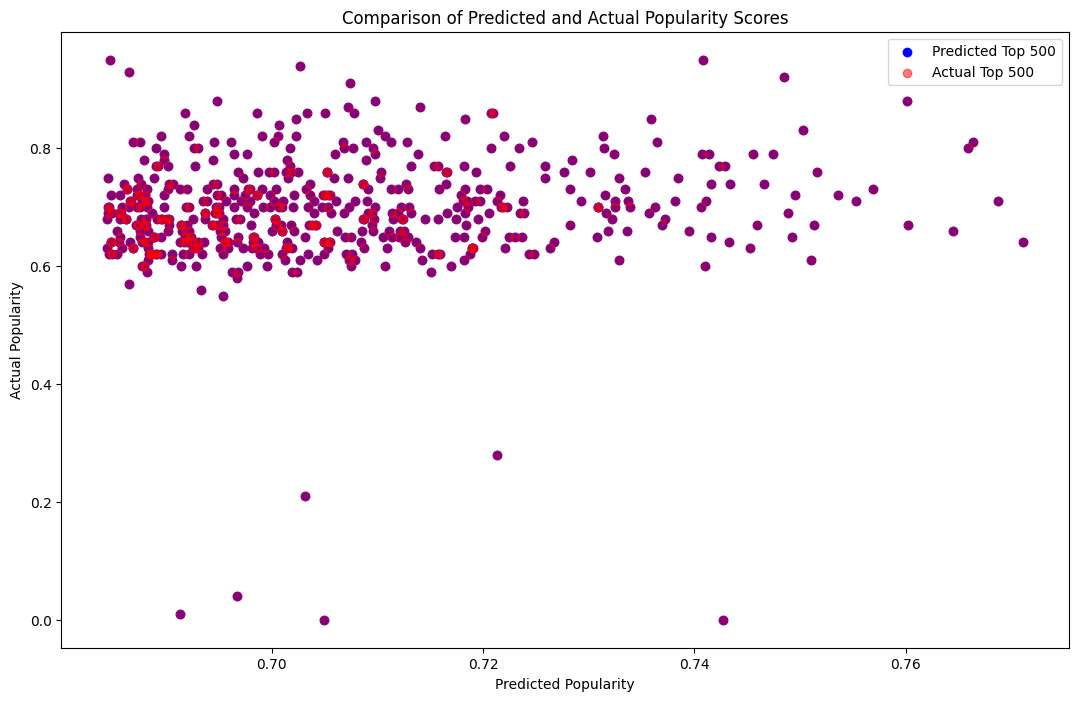

In [63]:
X_val['predicted_popularity'] = y_val_pred
X_val['actual_popularity'] = y_val
predicted_top_500_val = X_val.sort_values(by='predicted_popularity', ascending=False).head(500)
actual_top_500_val = X_val.sort_values(by='actual_popularity', ascending=False).head(500)
plt.figure(figsize=(13, 8))
plt.scatter(predicted_top_500_val['predicted_popularity'], predicted_top_500_val['actual_popularity'], color='blue', label='Predicted Top 500')
plt.scatter(predicted_top_500_val['predicted_popularity'], predicted_top_500_val['actual_popularity'], color='red', alpha=0.5, label='Actual Top 500')
plt.title('Comparison of Predicted and Actual Popularity Scores')
plt.xlabel('Predicted Popularity')
plt.ylabel('Actual Popularity')
plt.legend()
plt.show()


In [65]:
common_songs = pd.merge(predicted_top_500_val, actual_top_500_val)
print(f"Number of common songs in both top 500 lists: {len(common_songs)}")

Number of common songs in both top 500 lists: 150


In [40]:
predicted_top_2000 = filtered_df.sort_values(by='predicted_popularity', ascending=False).head(2000)
actual_top_2000 = filtered_df.sort_values(by='popularity', ascending=False).head(2000)

common_songs = pd.merge(predicted_top_2000, actual_top_2000, on='track_id')
print(f"Number of common songs in both top 2000 lists: {len(common_songs)}")

Number of common songs in both top 2000 lists: 469
